In [1]:
#########################################################################################
##
## Demo The Segmentation Results of Different Models on Oxford-IIIT Pet Dataset
##
## List:
## 1) U-Net Xception w/ supervised learning
## 2) Vanilla CNN w/ unsupervised learning following the ICASSP 2018 paper
##
## Author:  Peizhi Yan
##   Date:  Mar. 27, 2021
##
#########################################################################################

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import layers

import model.unet_xception as unet_xception 
import model.icassp as icassp 

import pet_dataset_handler as pet
from pet_dataset_handler import PetDataGenerator

import evaluation

W0409 14:47:31.503715 17980 deprecation.py:323] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
"""Load testing data"""
list_ids = []
for fname in os.listdir('./data/224x224/test'):
    if fname.startswith('_') == False and fname.endswith('.jpg'):
        list_ids.append(fname[:-4])
        
test_x, test_y = pet.load_data(data_path='./data/224x224/test', list_ids=list_ids, width=224, height=224)
test_y = np.argmax(test_y, axis=3)

print(test_x.shape)
print(test_y.shape)

(3669, 224, 224, 3)
(3669, 224, 224)


W0409 14:48:07.405828 17980 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0409 14:48:07.462827 17980 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0409 14:48:07.532826 17980 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0409 14:48:07.593828 17980 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0409 14:48:07.669824 17980 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


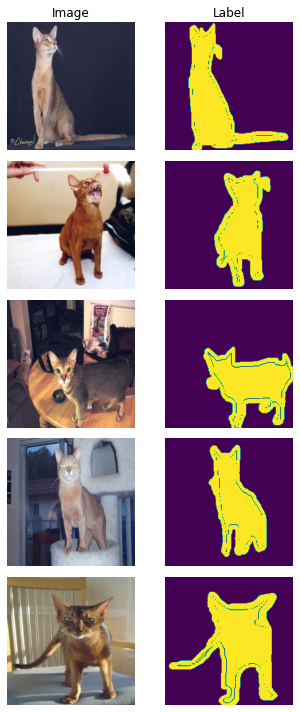

In [3]:
""" Display first 5 images and masks """
imgs = test_x[:5]
masks = test_y[:5]
plt.figure(figsize=(5,10))
for i in range(len(imgs)):
    ## Display Images
    plt.subplot(len(imgs),2,i*2+1)
    plt.imshow((imgs[i]+1.9)/3.8)
    if i == 0:
        plt.title('Image')
    plt.axis('off')
    ## Display Labels
    plt.subplot(len(imgs),2,i*2+2)
    plt.imshow(masks[i])
    plt.axis('off')
    if i == 0:
        plt.title('Label')

plt.tight_layout()
plt.show()

In [4]:
def post_supervised(pred):
    return np.argmax(pred, axis=3)

def post_icassp(pred):
    return np.argmax(1-pred, axis=3)

def post_pseudo(pred):
    THRESHOLD = np.mean(pred[:,:,:,0])
    return np.where(pred[:,:,:,0] > THRESHOLD, 1, 0)

def evaluate(model, test_x, test_y, post_processing):
    """My customized evaluate function"""
    EVAL_BATCH_SIZE = 1024 # evaluation batch size
    idx = 0
    iou = 0 # Intersection over Union
    ap = 0  # Average Precision
    while idx < len(test_x):
        batch_x = test_x[idx:idx+EVAL_BATCH_SIZE]
        batch_y = test_y[idx:idx+EVAL_BATCH_SIZE]
        pred = post_processing(model.predict(batch_x))
        iou += len(batch_x) * evaluation.mIOU(batch_y, pred)
        ap += len(batch_x) * evaluation.mAP(batch_y, pred)
        idx += EVAL_BATCH_SIZE
    miou = iou / len(test_x)
    mAP = ap / len(test_x)
    print("-------------------------------")
    print("mIOU", miou)
    print("mAP", mAP)
    print("-------------------------------")


### (Supervised) Xception network-based U-Net-like model

In [6]:
tf.reset_default_graph()
keras.backend.clear_session()
model = unet_xception.get_model(img_size=(224,224), num_classes=2)
model.summary()

# Trained through CCE loss w/o augmentation
model.load_weights('./saved_models/unet_cce_loss__no_aug/cce_loss__no_aug-011-0.164126-0.281592.h5')
evaluate(model, test_x, test_y, post_supervised)

# Trained through CCE loss w/ augmentation
model.load_weights('./saved_models/unet_cce_loss__aug/050-0.083638-0.212480.h5')
evaluate(model, test_x, test_y, post_supervised)

# Traine through Dice loss w/o augmentation
model.load_weights('./saved_models/unet_dice_loss__aug/050-0.089996-0.065419.h5')
evaluate(model, test_x, test_y, post_supervised)

# Traine through Dice loss w/ augmentation
model.load_weights('./saved_models/unet_dice_loss__no_aug/045-0.022081-0.084502.h5')
evaluate(model, test_x, test_y, post_supervised)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

mIOU 0.7711092613678677
mAP 0.8781368591412764
mIOU 0.8314163261685442
mAP 0.9199037902967818
mIOU 0.8229548566644592
mAP 0.9143581088907211
mIOU 0.782547889089522
mAP 0.8989693983361731


### (Unsupervised) ICASSP 2018 paper algorithm

In [7]:
tf.reset_default_graph()
keras.backend.clear_session()
model = icassp.get_model(img_size=(224,224), num_classes=2)
model.summary()

# Mu = 1 w/o augmentation
model.load_weights('./saved_models/icassp_mu1_clusters2__aug-False/047-0.000860-0.000772.h5')
evaluate(model, test_x, test_y, post_icassp)

# Mu = 1 w/ augmentation
model.load_weights('./saved_models/icassp_mu1_clusters2__aug-True/050-0.000776-0.000777.h5')
evaluate(model, test_x, test_y, post_icassp)

# Mu = 10 w/o augmentation
model.load_weights('./saved_models/icassp_mu10_clusters2__aug-False/049-0.000866-0.000767.h5')
evaluate(model, test_x, test_y, post_icassp)

# Mu = 10 w/ augmentation
model.load_weights('./saved_models/icassp_mu10_clusters2__aug-True/048-0.000845-0.000741.h5')
evaluate(model, test_x, test_y, post_icassp)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 100)     2800      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 100)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 100)     400       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 100)     90100     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 100)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 100)     400   

### (Unsupervised) Trained on Pseudo Labels - initial iteration

In [18]:
tf.reset_default_graph()
keras.backend.clear_session()

EXPERIMENT_NAME = 'pseudo_label__aug-True_iter-0' # initial training iteration
model = unet_xception.get_model(img_size=(224,224), num_classes=1)
model.load_weights('./saved_models/'+EXPERIMENT_NAME+'.h5')

evaluate(model, test_x, test_y, post_pseudo)


-------------------------------
mIOU 0.5262856875255515
mAP 0.6109401735429012
-------------------------------


### (Unsupervised) Trained on Refined Pseudo Labels - first iteration

In [5]:
EXPERIMENT_NAME = 'pseudo_label__aug-True_iter-1.1'

tf.reset_default_graph()
keras.backend.clear_session()

model = unet_xception.get_model(img_size=(224,224), num_classes=2)
model.load_weights('./saved_models/'+EXPERIMENT_NAME+'.h5')

evaluate(model, test_x, test_y, post_supervised)

W0409 14:07:36.663882  9152 deprecation.py:506] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


-------------------------------
mIOU 0.5824750924795445
mAP 0.6533490952809468
-------------------------------


In [5]:
EXPERIMENT_NAME = 'pseudo_label__aug-True_iter-1.2'

tf.reset_default_graph()
keras.backend.clear_session()

model = unet_xception.get_model(img_size=(224,224), num_classes=2)
model.load_weights('./saved_models/'+EXPERIMENT_NAME+'.h5')

evaluate(model, test_x, test_y, post_supervised)

W0409 14:48:08.350866 17980 deprecation.py:506] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


-------------------------------
mIOU 0.5684289580143965
mAP 0.6441845391839135
-------------------------------
